# Assignment — Node embedding

In [ ]:
import numpy as np
import requests
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD, PCA
from time import time
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import networkx as nx
import matplotlib.pyplot as plt

### Cora dataset EDA

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Let us take a closer look at this dataset.

In [ ]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_cites.txt'
open('cora_cites.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_content.txt'
open('cora_content.txt', 'wb').write(requests.get(url).content);

Number of nodes in the graph

In [ ]:
cora = nx.read_edgelist('cora_cites.txt')
len(cora)

2708

Number of nodes in a gigantic connected component (GCC)

In [ ]:
gcc_nodes = sorted(list(nx.connected_components(cora)), 
                   key=lambda x: len(x))[-1]
gcc_cora = cora.subgraph(gcc_nodes).copy()
len(gcc_cora)

2485

Nodes content

In [ ]:
cora_content = pd.read_csv('cora_content.txt', sep='	', 
                           header=None, index_col=0)
cora_content.index = cora_content.index.astype('str')
cora_content.index.name = 'node'
cora_content.iloc[:5, :20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
node,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. In this assignment, we will only work with categories and will not touch any information about words.

Examples of node categories

In [ ]:
category = cora_content.loc[gcc_nodes, [1434]]
category = category.rename(columns={1434: 'category_name'})
category.head()

,category_name
node,
155736,Theory
51052,Probabilistic_Methods
60159,Neural_Networks
14062,Genetic_Algorithms
48550,Neural_Networks


Category distribution

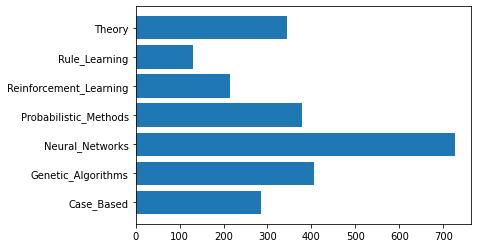

In [ ]:
plt.barh(*np.unique(category, return_counts=True));

Rename categories to integer numbers (ids)

In [ ]:
category['category_id'] = np.unique(category.category_name, 
                                    return_inverse = True)[1]
category.head()

,category_name,category_id
node,,
155736,Theory,6
51052,Probabilistic_Methods,3
60159,Neural_Networks,2
14062,Genetic_Algorithms,1
48550,Neural_Networks,2


Assortativity coefficient

In [ ]:
nx.set_node_attributes(gcc_cora, category.category_id.to_dict(), 'category')
gcc_cora = nx.convert_node_labels_to_integers(gcc_cora)
round(nx.attribute_assortativity_coefficient(gcc_cora, 'category'), 2)

0.76

### Task 1. Node embedding visualization (0 points)

In [ ]:
!pip install gensim==4.0.0
!pip install karateclub

     |████████████████████████████████| 23.9 MB 75.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 62 kB 497 kB/s 
     |████████████████████████████████| 1.8 MB 8.7 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.3-py3-none-any.whl size=97754 sha256=43e536f0bbf4d8ea34e77a2a9e6629b01cff2368a8f13f6143d9637eb735010f
  Stored in directory: /root/.cache/pip/wheels/7a/09/80/0d50455fd4e297e88f8f38a711c6f4849e6bd1a330000dde3d
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=0046dbb39ff52df7591bf67b84a80489b267c24910bc85e661147d68ac949762
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built karateclub python-Levenshtein


In [ ]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Let us compare embedding algorithms that we saw in previous assignments: 
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

There is a usefull python package [*Karate Club*](https://github.com/benedekrozemberczki/karateclub) that contains implementations of these algorithms. Also we will use sklearn implementation of truncated SVD.

Embedding algorithms in Karate Club have a general interface

```
model.fit(graph)
embedding = model.get_embedding()
```

However, the one inconvenient thing is that Walklets make a concatenation of Word2Vec embeddings to obtain final embeddings. In this way, the output dimensionality will be Word2Vec dimensionality multiplied by window size. A piece of source code:

```python
def get_embedding(self) -> np.array:
    r"""Getting the node embedding.

    Return types:
        * **embedding** *(Numpy array)* - The embedding of nodes.
    """
    return np.concatenate(self._embedding, axis=1)
```

Sometimes, it is usefull to have deep representation of nodes, but  we want to compare embeddings with the same dimensionality, so let us define our own class `MeanWalklets` that inherits `Walklets` and returns average embeddings in the `get_embedding` method.

In [ ]:
class MeanWalklets(Walklets):
    def get_embedding(self):
        # YOUR CODE HERE
        return np.mean(self._embedding, axis=0)

In [ ]:
test_model = MeanWalklets()
test_model.fit(nx.karate_club_graph())
test_emb = test_model.get_embedding()
assert test_emb.shape == (34, 32)

Now let us visualize the 2d embeddings.

Write a function `xy_embeddings` that takes a graph, compute 16d embeddings, reduce them into 2d via PCA and returns in the order:
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

*Hints:*
* *Suggested hyperparameters for DeepWalk and Walklets are `walk_number=10`, `walk_length=30`, `window_size=10`*
* *You do not need reduce Walklets embeddgins to 2d, just directly use `PCAWalklets` with dimensionality 2*


Теперь давайте визуализируем двумерные вложения.

Напишите функцию `xy_embeddings`, которая берет график, вычисляет 16-мерные вложения, сводит их к 2-мерным с помощью PCA и возвращает в следующем порядке:
* Лапласовы собственные карты
* Усеченный SVD матрицы смежности
* Глубокая прогулка
* Прогулки

*Подсказки:*
* * Предлагаемые гиперпараметры для DeepWalk и Walklets: `walk_number=10`, `walk_length=30`, `window_size=10`*
* * Вам не нужно уменьшать вложения Walklets до 2d, просто используйте `PCAWalklets` с размерностью 2*

In [ ]:
def xy_embeddings(_graph):
    graph = _graph.copy()
    bar = tqdm(total=4)
    
    model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    model = PCA(n_components=2)
    walklets_emb = model.fit_transform(emb)
    bar.update(1)

    model = LaplacianEigenmaps(dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    model = PCA(n_components=2)
    lap_eig_emb = model.fit_transform(emb)
    bar.update(1)
    
    model = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    model = PCA(n_components=2)
    deepwalk_emb = model.fit_transform(emb)
    bar.update(1)

    A = nx.to_numpy_array(graph)
    model = TruncatedSVD(n_components=16)
    emb = model.fit_transform(A)
    model = PCA(n_components=2)
    trunc_svd_emb = model.fit_transform(emb)
    bar.update(1)
    return lap_eig_emb, trunc_svd_emb, deepwalk_emb, walklets_emb

In [ ]:
laplacian_emb, svd_emb, deep_walk_emb, walklets_emb = xy_embeddings(gcc_cora)
assert (deep_walk_emb.shape == laplacian_emb.shape 
        == svd_emb.shape == walklets_emb.shape == (2485, 2))
assert -0.5 < laplacian_emb.min() < laplacian_emb.max() < 0.5
assert svd_emb[0].sum() > 11
assert round(abs(np.corrcoef(deep_walk_emb[:, 0], deep_walk_emb[:, 1])[0][1]), 
             2) == 0
assert round(abs(np.corrcoef(walklets_emb[:, 0], walklets_emb[:, 1])[0][1]), 
             2) == 0

  0%|          | 0/4 [00:00<?, ?it/s]

Next, here we get a list of category ids to color data points

In [ ]:
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
category_id[:10]

[1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

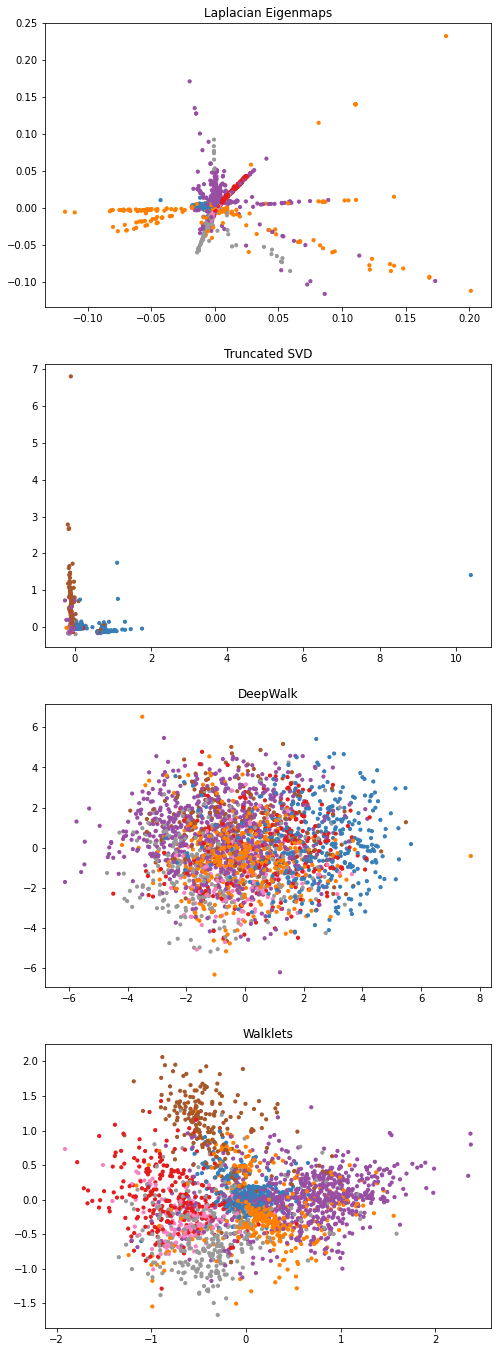

In [ ]:
plt.figure(figsize=(8, 6*4))
cases = [[laplacian_emb, 'Laplacian Eigenmaps'], 
         [svd_emb, 'Truncated SVD'], 
         [deep_walk_emb, 'DeepWalk'], 
         [walklets_emb, 'Walklets']]
for i, (emb, title) in enumerate(cases):
    plt.subplot(4, 1, i+1)
    plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
    plt.title(title)

### Task 2. Test size dependency (3 points)

In [ ]:
!pip install gensim==4.0.0
!pip install karateclub

In [ ]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Let us compare the quality of embedding algorithms on classification tasks depending on the size of test set.

Write a function `embeddings_score` that takes a graph and computes 16d embeddigns, splits the dataset (X is embedding, y is category id) into train and test sets, fit `GradientBoostingClassifier` and returns a list of lists:
* Micro-F1 score of Laplacian Eigenmaps for the test size 0.99, 0.95, 0.9, 0.8, 0.7
* The same for Truncated SVD
* The same for Deepwalk
* The same for Walklets

*Hints:* 
* *Use `train_test_split` splitting method from sklearn*
* *Use `f1_score(y_test, y_pred, average='micro')` method from sklearn to calculate Micro-F1 score*
* *It is ok if it takes about 2 minutes in Colab*


Сравним качество встраивания алгоритмов в задачи классификации в зависимости от размера тестовой выборки.

Напишите функцию embeddings_score, которая берет график и вычисляет 16d вложений, разбивает набор данных (X — встраивание, y — идентификатор категории) на обучающие и тестовые наборы, соответствует GradientBoostingClassifier и возвращает список списков:
* Оценка Micro-F1 лапласовских собственных карт для размера теста 0,99, 0,95, 0,9, 0,8, 0,7
* То же для Усеченной SVD
* То же самое для Deepwalk
* То же самое для Walklets

*Подсказки:*
* *Используйте метод разделения `train_test_split` из sklearn*
* *Используйте метод `f1_score(y_test, y_pred, medium='micro')` из sklearn для расчета оценки Micro-F1*
* *Это нормально, если в Colab это займет около 2 минут*

In [ ]:
def embeddings_score(_graph):
    graph = _graph.copy()
    bar = tqdm(total=4)
    score_MeanWalklets = []
    score_LaplacianEigenmaps = []
    score_DeepWalk = []
    score_TruncatedSVD = []

    model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)

    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_MeanWalklets.append(f1_score(y_true, y_test, average='micro'))

    model = LaplacianEigenmaps(dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_LaplacianEigenmaps.append(f1_score(y_true, y_test, average='micro'))

    model = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_DeepWalk.append(f1_score(y_true, y_test, average='micro'))

    A = nx.to_numpy_array(graph)
    model = TruncatedSVD(n_components=16)
    emb = model.fit_transform(A)
    bar.update(1)

    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_TruncatedSVD.append(f1_score(y_true, y_test, average='micro'))

    return [np.array(score_LaplacianEigenmaps), np.array(score_TruncatedSVD), np.array(score_DeepWalk), np.array(score_MeanWalklets)]

In [ ]:
scores = embeddings_score(gcc_cora)
scores = np.array(scores)
assert scores.shape == (4, 5)
assert scores.mean() > 0.5
X = np.stack([np.ones(5), np.arange(5)], axis=1)
y = scores.mean(axis=0)
assert (np.linalg.inv(X.T @ X) @ X.T @ y)[0] > 0.4
mean_res = scores.mean(axis=1)
assert mean_res[0] > mean_res[3] > mean_res[1] > mean_res[2]

  0%|          | 0/4 [00:00<?, ?it/s]

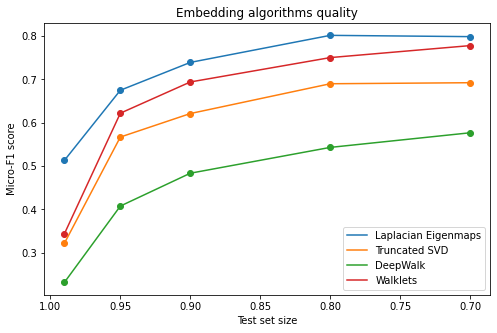

In [ ]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores):
    plt.plot([0.99, 0.95, 0.9, 0.8, 0.7], score, label=labels[i])
    plt.scatter([0.99, 0.95, 0.9, 0.8, 0.7], score)
plt.legend()
plt.title('Embedding algorithms quality')
plt.xlabel('Test set size')
plt.ylabel('Micro-F1 score')
plt.gca().invert_xaxis()
plt.show()

### Task 3. Embedding dimensionality importance (3 points)

In [ ]:
!pip install gensim==4.0.0
!pip install karateclub

In [ ]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Another important property of the embedding is an ability to represent nodes in low-dimensional space. It will be great to quickly compress the most important and drop all excess imformation. Let us check how the dimensionality affects to quality and time cost.

Write a function `embeddings_dim` that takes a graph, computes embeddings, splits dataset into train and test sets with test size 0.95, computes Micro-F1 scores, time costs and returns a tuple:
* list of lists:
  * Micro-F1 score for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d
* list of lists:
  * Time cost (seconds) for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d

*Hints:*
* *Use `time()` to get a current time moment*
* *It is ok if it takes about 4 minutes in Colab*

Еще одним важным свойством встраивания является возможность представлять узлы в низкоразмерном пространстве. Будет здорово быстро сжать самое важное и отбросить всю лишнюю информацию. Проверим, как влияет размерность на качество и временные затраты.

Напишите функцию `embeddings_dim`, которая берет график, вычисляет вложения, разбивает набор данных на обучающие и тестовые наборы с размером теста 0,95, вычисляет баллы Micro-F1, временные затраты и возвращает кортеж:
* список списков:
   * Оценка Micro-F1 для 8d лапласовских собственных карт, усеченного SVD, DeepWalk, Walklets
   * То же для 16д
   * То же для 32d
   * То же самое для 64д
   * То же для 128d
* список списков:
   * Затраты времени (секунды) для 8-дневных лапласовских собственных карт, усеченных SVD, DeepWalk, Walklets
   * То же для 16д
   * То же для 32d
   * То же самое для 64д
   * То же для 128d

*Подсказки:*
* *Используйте `time()`, чтобы получить текущий момент времени*
* *Это нормально, если в Colab это займет около 4 минут*

In [ ]:
import time

start = time.time()
print("hello")
end = time.time()
print(end - start)

hello
0.007895231246948242


In [ ]:
import time

graph = gcc_cora.copy()
bar = tqdm(total=20)
score_MeanWalklets = []
score_LaplacianEigenmaps = []
score_DeepWalk = []
score_TruncatedSVD = []

time_MeanWalklets = []
time_LaplacianEigenmaps = []
time_DeepWalk = []
time_TruncatedSVD = []

for i in [8, 16, 32, 64, 128]:
  start = time.time()
  model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=i)
  model.fit(graph)
  emb = model.get_embedding() # 16d
  bar.update(1)
  X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
  clf = GradientBoostingClassifier().fit(X_train, y_train)
  y_true = clf.predict(X_test)
  score_MeanWalklets.append(f1_score(y_true, y_test, average='micro'))
  end = time.time()
  time_MeanWalklets.append(end - start)

for i in [8, 16, 32, 64, 128]:
  start = time.time()
  model = LaplacianEigenmaps(dimensions=i)
  model.fit(graph)
  emb = model.get_embedding() # 16d
  bar.update(1)
  X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
  clf = GradientBoostingClassifier().fit(X_train, y_train)
  y_true = clf.predict(X_test)
  score_LaplacianEigenmaps.append(f1_score(y_true, y_test, average='micro'))
  end = time.time()
  time_LaplacianEigenmaps.append(end - start)

for i in [8, 16, 32, 64, 128]:
  start = time.time()
  model = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=16)
  model.fit(graph)
  emb = model.get_embedding() # 16d
  bar.update(1)
  X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
  clf = GradientBoostingClassifier().fit(X_train, y_train)
  y_true = clf.predict(X_test)
  score_DeepWalk.append(f1_score(y_true, y_test, average='micro'))
  end = time.time()
  time_DeepWalk.append(end - start)

A = nx.to_numpy_array(graph)
for i in [8, 16, 32, 64, 128]:
  start = time.time()  
  model = TruncatedSVD(n_components=i)
  emb = model.fit_transform(A)
  bar.update(1)
  X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
  clf = GradientBoostingClassifier().fit(X_train, y_train)
  y_true = clf.predict(X_test)
  score_TruncatedSVD.append(f1_score(y_true, y_test, average='micro'))
  end = time.time()
  time_TruncatedSVD.append(end - start)

score = [[score_LaplacianEigenmaps[0], score_TruncatedSVD[0], score_DeepWalk[0], score_MeanWalklets[0]],\
[score_LaplacianEigenmaps[1], score_TruncatedSVD[1], score_DeepWalk[1], score_MeanWalklets[1]],\
[score_LaplacianEigenmaps[2], score_TruncatedSVD[2], score_DeepWalk[2], score_MeanWalklets[2]],\
[score_LaplacianEigenmaps[3], score_TruncatedSVD[3], score_DeepWalk[3], score_MeanWalklets[3]],\
[score_LaplacianEigenmaps[4], score_TruncatedSVD[4], score_DeepWalk[4], score_MeanWalklets[4]]]

time = [[time_LaplacianEigenmaps[0], time_TruncatedSVD[0], time_DeepWalk[0], time_MeanWalklets[0]],\
[time_LaplacianEigenmaps[1], time_TruncatedSVD[1], time_DeepWalk[1], time_MeanWalklets[1]],\
[time_LaplacianEigenmaps[2], time_TruncatedSVD[2], time_DeepWalk[2], time_MeanWalklets[2]],\
[time_LaplacianEigenmaps[3], time_TruncatedSVD[3], time_DeepWalk[3], time_MeanWalklets[3]],\
[time_LaplacianEigenmaps[4], time_TruncatedSVD[4], time_DeepWalk[4], time_MeanWalklets[4]]]



  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
scores, time_cost = np.array(score), np.array(time)

assert scores.shape == time_cost.shape == (5, 4)
smean = scores.mean(axis=0)
assert smean.argmin() == 2
assert smean[1] < smean[0]
assert smean[1] < smean[3]
assert smean.mean() > 0.5
tcmean = time_cost.mean(axis=0)
assert tcmean.argmin() in [0, 1]
assert tcmean.argmax() == 3
assert time_cost[0, 0] < time_cost[-1, 0]

In [ ]:
time_MeanWalklets

[30.789907217025757,
 28.634704113006592,
 29.663451433181763,
 34.068843841552734]

In [ ]:
score_MeanWalklets

[0.6048284625158831,
 0.6230410842863193,
 0.6632782719186785,
 0.6374417619652689]

In [ ]:
def embeddings_score(_graph):
    graph = _graph.copy()
    bar = tqdm(total=4)
    score_MeanWalklets = []
    score_LaplacianEigenmaps = []
    score_DeepWalk = []
    score_TruncatedSVD = []

    model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)

    for i in [16, 32, 64, 128]:
      model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=i)
      model.fit(graph)
      emb = model.get_embedding() # 16d
      bar.update(1)
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_MeanWalklets.append(f1_score(y_true, y_test, average='micro'))

    model = LaplacianEigenmaps(dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_LaplacianEigenmaps.append(f1_score(y_true, y_test, average='micro'))

    model = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_DeepWalk.append(f1_score(y_true, y_test, average='micro'))

    A = nx.to_numpy_array(graph)
    model = TruncatedSVD(n_components=16)
    emb = model.fit_transform(A)
    bar.update(1)

    for i in [0.99, 0.95, 0.9, 0.8, 0.7]:
      X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=i, random_state=42)
      clf = GradientBoostingClassifier().fit(X_train, y_train)
      y_true = clf.predict(X_test)
      score_TruncatedSVD.append(f1_score(y_true, y_test, average='micro'))

    return [np.array(score_LaplacianEigenmaps), np.array(score_TruncatedSVD), np.array(score_DeepWalk), np.array(score_MeanWalklets)]

In [ ]:
def embeddings_dim(_graph):
  import time

  graph = gcc_cora.copy()
  bar = tqdm(total=20)
  score_MeanWalklets = []
  score_LaplacianEigenmaps = []
  score_DeepWalk = []
  score_TruncatedSVD = []

  time_MeanWalklets = []
  time_LaplacianEigenmaps = []
  time_DeepWalk = []
  time_TruncatedSVD = []

  for i in [8, 16, 32, 64, 128]:
    start = time.time()
    model = MeanWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=i)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
    clf = GradientBoostingClassifier().fit(X_train, y_train)
    y_true = clf.predict(X_test)
    score_MeanWalklets.append(f1_score(y_true, y_test, average='micro'))
    end = time.time()
    time_MeanWalklets.append(end - start)

  for i in [8, 16, 32, 64, 128]:
    start = time.time()
    model = LaplacianEigenmaps(dimensions=i)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
    clf = GradientBoostingClassifier().fit(X_train, y_train)
    y_true = clf.predict(X_test)
    score_LaplacianEigenmaps.append(f1_score(y_true, y_test, average='micro'))
    end = time.time()
    time_LaplacianEigenmaps.append(end - start)

  for i in [8, 16, 32, 64, 128]:
    start = time.time()
    model = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=16)
    model.fit(graph)
    emb = model.get_embedding() # 16d
    bar.update(1)
    X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
    clf = GradientBoostingClassifier().fit(X_train, y_train)
    y_true = clf.predict(X_test)
    score_DeepWalk.append(f1_score(y_true, y_test, average='micro'))
    end = time.time()
    time_DeepWalk.append(end - start)

  A = nx.to_numpy_array(graph)
  for i in [8, 16, 32, 64, 128]:
    start = time.time()  
    model = TruncatedSVD(n_components=i)
    emb = model.fit_transform(A)
    bar.update(1)
    X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=42)
    clf = GradientBoostingClassifier().fit(X_train, y_train)
    y_true = clf.predict(X_test)
    score_TruncatedSVD.append(f1_score(y_true, y_test, average='micro'))
    end = time.time()
    time_TruncatedSVD.append(end - start)

  score = [[score_LaplacianEigenmaps[0], score_TruncatedSVD[0], score_DeepWalk[0], score_MeanWalklets[0]],\
  [score_LaplacianEigenmaps[1], score_TruncatedSVD[1], score_DeepWalk[1], score_MeanWalklets[1]],\
  [score_LaplacianEigenmaps[2], score_TruncatedSVD[2], score_DeepWalk[2], score_MeanWalklets[2]],\
  [score_LaplacianEigenmaps[3], score_TruncatedSVD[3], score_DeepWalk[3], score_MeanWalklets[3]],\
  [score_LaplacianEigenmaps[4], score_TruncatedSVD[4], score_DeepWalk[4], score_MeanWalklets[4]]]

  time = [[time_LaplacianEigenmaps[0], time_TruncatedSVD[0], time_DeepWalk[0], time_MeanWalklets[0]],\
  [time_LaplacianEigenmaps[1], time_TruncatedSVD[1], time_DeepWalk[1], time_MeanWalklets[1]],\
  [time_LaplacianEigenmaps[2], time_TruncatedSVD[2], time_DeepWalk[2], time_MeanWalklets[2]],\
  [time_LaplacianEigenmaps[3], time_TruncatedSVD[3], time_DeepWalk[3], time_MeanWalklets[3]],\
  [time_LaplacianEigenmaps[4], time_TruncatedSVD[4], time_DeepWalk[4], time_MeanWalklets[4]]]

  return score, time

In [ ]:
scores, time_cost = embeddings_dim(gcc_cora)
scores, time_cost = np.array(scores), np.array(time_cost)
assert scores.shape == time_cost.shape == (5, 4)
smean = scores.mean(axis=0)
assert smean.argmin() == 2
assert smean[1] < smean[0]
assert smean[1] < smean[3]
assert smean.mean() > 0.5
tcmean = time_cost.mean(axis=0)
assert tcmean.argmin() in [0, 1]
assert tcmean.argmax() == 3
assert time_cost[0, 0] < time_cost[-1, 0]

  0%|          | 0/20 [00:00<?, ?it/s]

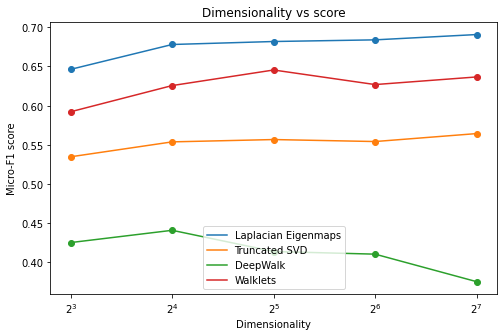

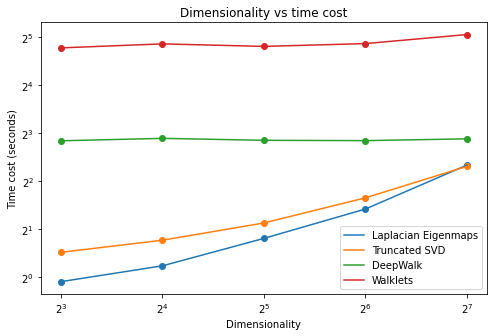

In [ ]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores.T):
    plt.plot([8, 16, 32, 64, 128], score, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], score)
plt.legend()
plt.xscale('log', basex=2)
plt.xlabel('Dimensionality')
plt.ylabel('Micro-F1 score')
plt.title('Dimensionality vs score')
plt.show()

plt.figure(figsize=(8, 5))
for i, cost in enumerate(time_cost.T):
    plt.plot([8, 16, 32, 64, 128], cost, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], cost)
plt.legend()
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.xlabel('Dimensionality')
plt.ylabel('Time cost (seconds)')
plt.title('Dimensionality vs time cost')
plt.show()

### Task 4. Node2Vec model (4 points)

In [ ]:
!pip install gensim==4.0.0

In [ ]:
from gensim.models.word2vec import Word2Vec

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to the DeepWalk, but used *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/node_embedding.png' width=300>

For example, we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with a random walk.

In [ ]:
def biased_random_walk(G, node, path_length, p, q):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
rw = biased_random_walk(gcc_cora, 0, 10, 0.1, 0.5)
assert len(rw) == 10
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=0.001, q=1000)
assert rw[0] == rw[2]
assert rw[1] == rw[3]
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=1000, q=0.001)
assert len(set(rw)) >= 3

Here are auxiliary methods that generates biased random walks and encode this walks using Word2Vec model.

In [ ]:
def biased_random_walks(G, walk_number, walk_length, p, q):
    walks = []
    for node in tqdm(G.nodes):
        for _ in range(walk_number):
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

def node2vec_encode(G, walks, dimensions, window_size):
    walks_str = walks.astype('str').tolist()
    model = Word2Vec(walks_str, vector_size=dimensions, hs=1, sg=1, 
                     alpha=0.05, epochs=1, window=window_size, )
    embedding = np.array([model.wv[str(n)] for n in range(len(G))])
    return embedding

In [ ]:
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=0.25, q=0.5)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
assert emb.shape == (2485, 16)

Write a function `grid_search_pq`. Using 0.95 test set size, run the grid search for `GradientBoostingClassifier` and find the best values for $p, q \in \{0.25, 0.50, 1, 2, 4\}$ with respect to Micro-F1 score. Return the best $p, q$.

*Hints:*
* *Suggested hyperparameters are `walk_number=10`, `walk_length=30`, `window_size=10`, `dimensions=16`*
* *To pass time limits, calculate the best `p` and `q` and then rewrite the function as*

```python
def grid_search_pq(graph):
    return best_p, best_q
```

In [ ]:
def grid_search_pq(graph):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
best_p, best_q = grid_search_pq(gcc_cora)
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=best_p, q=best_q)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=0)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
assert f1_score(y_test, y_pred, average='micro') > 0.65

In [ ]:
plt.figure(figsize=(8, 6))
model = PCA(n_components=2)
model.fit(emb)
emb = model.transform(emb)
plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
plt.title('Node2Vec')
plt.show()